# PCA and k-means

## Setting up

In [21]:
"""
Author      : Yi-Chieh Wu, Sriram Sankararaman
"""
import time

# numpy and scipy libraries
import numpy as np
from scipy import stats

# matplotlib libraries
import matplotlib.pyplot as plt
import collections

In [22]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import sys
# Change the path below to the path where your folder locates
# where you have util.py
### ========== TODO : START ========== ###
sys.path.append('/content/drive/My Drive/Colab Notebooks/CSM146/PS4')
### ========== TODO : START ========== ###


In [24]:
import util
from util import *

## Point, Cluster and Set of Clusters classes

In [25]:
######################################################################
# classes
######################################################################

class Point(object) :

    def __init__(self, name, label, attrs) :
        """
        A data point.

        Attributes
        --------------------
            name  -- string, name
            label -- string, label
            attrs -- numpy arrray of shape (d, ) where d is the number of features
        """

        self.name = name
        self.label = label
        self.attrs = attrs


    #============================================================
    # utilities
    #============================================================

    def distance(self, other) :
        """
        Return Euclidean distance of this point with other point.

        Parameters
        --------------------
            other -- Point, point to which we are measuring distance

        Returns
        --------------------
            dist  -- float, Euclidean distance
        """
        # Euclidean distance metric
        return np.linalg.norm(self.attrs-other.attrs)


    def __str__(self) :
        """
        Return string representation.
        """
        return "%s : (%s, %s)" % (self.name, str(self.attrs), self.label)

In [26]:
class Cluster(object) :

    def __init__(self, points) :
        """
        A cluster (set of points).

        Attributes
        --------------------
            points -- list of Points, cluster elements
        """
        self.points = points


    def __str__(self) :
        """
        Return string representation.
        """
        s = ""
        for point in self.points :
            s += str(point)
        return s

    #============================================================
    # utilities
    #============================================================

    def purity(self) :
        """
        Compute cluster purity.

        Returns
        --------------------
            n           -- int, number of points in this cluster
            num_correct -- int, number of points in this cluster
                                with label equal to most common label in cluster
        """
        labels = []
        for p in self.points :
            labels.append(p.label)

        cluster_label, count = stats.mode(labels)
        return len(labels), np.float64(count)


    def centroid(self) :
        """
        Compute centroid of this cluster.

        Returns
        --------------------
            centroid -- Point, centroid of cluster
        """

        ### ========== TODO : START ========== ###
        # part 2b: implement
        # set the centroid label to any value (e.g. the most common label in this cluster)

        attributes = [p.attrs for p in self.points]
        labels = [p.label for p in self.points]
        label = stats.mode(labels)
        attributes = np.mean(attributes, axis=0)
        centroid = Point('centroid', label, attributes)

        return centroid
        ### ========== TODO : END ========== ###



    def medoid(self) :
        """
        Compute medoid of this cluster, that is, the point in this cluster
        that is closest to all other points in this cluster.

        Returns
        --------------------
            medoid -- Point, medoid of this cluster
        """

        ### ========== TODO : START ========== ###
        # part 2b: implement
        medoid = None
        list_dist = []
        for p in self.points:
          distance = 0
          for j in self.points:
            distance += p/distance(j)
          list_dist.append(distance)
        medoid = self.points[np.argmin(list_dist)]
        return medoid
        ### ========== TODO : END ========== ###


    def equivalent(self, other) :
        """
        Determine whether this cluster is equivalent to other cluster.
        Two clusters are equivalent if they contain the same set of points
        (not the same actual Point objects but the same geometric locations).

        Parameters
        --------------------
            other -- Cluster, cluster to which we are comparing this cluster

        Returns
        --------------------
            flag  -- bool, True if both clusters are equivalent or False otherwise
        """

        if len(self.points) != len(other.points) :
            return False

        matched = []
        for point1 in self.points :
            for point2 in other.points :
                if point1.distance(point2) == 0 and point2 not in matched :
                    matched.append(point2)
        return len(matched) == len(self.points)

In [27]:
class ClusterSet(object):

    def __init__(self) :
        """
        A cluster set (set of clusters).

        Parameters
        --------------------
            members -- list of Clusters, clusters that make up this set
        """
        self.members = []


    #============================================================
    # utilities
    #============================================================

    def centroids(self) :
        """
        Return centroids of each cluster in this cluster set.

        Returns
        --------------------
            centroids -- list of Points, centroids of each cluster in this cluster set
        """

        ### ========== TODO : START ========== ###
        # part 2b: implement

        return [mbr.centroid() for mbr in self.members]
        ### ========== TODO : END ========== ###


    def medoids(self) :
        """
        Return medoids of each cluster in this cluster set.

        Returns
        --------------------
            medoids -- list of Points, medoids of each cluster in this cluster set
        """

        ### ========== TODO : START ========== ###
        # part 2b: implement
        return [mbr.centroid() for mbr in self.members]
        ### ========== TODO : END ========== ###


    def score(self) :
        """
        Compute average purity across clusters in this cluster set.

        Returns
        --------------------
            score -- float, average purity
        """

        total_correct = 0
        total = 0
        for c in self.members :
            n, n_correct = c.purity()
            total += n
            total_correct += n_correct
        return total_correct / float(total)


    def equivalent(self, other) :
        """
        Determine whether this cluster set is equivalent to other cluster set.
        Two cluster sets are equivalent if they contain the same set of clusters
        (as computed by Cluster.equivalent(...)).

        Parameters
        --------------------
            other -- ClusterSet, cluster set to which we are comparing this cluster set

        Returns
        --------------------
            flag  -- bool, True if both cluster sets are equivalent or False otherwise
        """

        if len(self.members) != len(other.members):
            return False

        matched = []
        for cluster1 in self.members :
            for cluster2 in other.members :
                if cluster1.equivalent(cluster2) and cluster2 not in matched:
                    matched.append(cluster2)
        return len(matched) == len(self.members)


    #============================================================
    # manipulation
    #============================================================

    def add(self, cluster):
        """
        Add cluster to this cluster set (only if it does not already exist).

        If the cluster is already in this cluster set, raise a ValueError.

        Parameters
        --------------------
            cluster -- Cluster, cluster to add
        """

        if cluster in self.members :
            raise ValueError

        self.members.append(cluster)

## k-means and k-medoids algorithms

In [28]:
######################################################################
# k-means and k-medoids
######################################################################

def random_init(points, k) :
    """
    Randomly select k unique elements from points to be initial cluster centers.

    Parameters
    --------------------
        points         -- list of Points, dataset
        k              -- int, number of clusters

    Returns
    --------------------
        initial_points -- list of k Points, initial cluster centers
    """
    ### ========== TODO : START ========== ###
    # part 2c: implement (hint: use np.random.choice)

    return np.random.choice(points, k, replace=False)


    ### ========== TODO : END ========== ###


def cheat_init(points) :
    """
    Initialize clusters by cheating!

    Details
    - Let k be number of unique labels in dataset.
    - Group points into k clusters based on label (i.e. class) information.
    - Return medoid of each cluster as initial centers.

    Parameters
    --------------------
        points         -- list of Points, dataset

    Returns
    --------------------
        initial_points -- list of k Points, initial cluster centers
    """
    ### ========== TODO : START ========== ###
    # part 2f: implement
    labels = set([point.label for point in points])
    clusterSet = ClusterSet()
    for k in labels:
      res = []
      for p in points:
        if p.label == k:
          res.append(p)
      k_cluster = Cluster(res)
      clusterSet.add(k_cluster)
    return clusterSet.medoids()
    ### ========== TODO : END ========== ###

def kAverages(points, k, average, init='random', plot=False) :
    """
    Cluster points into k clusters using variations of k-means algorithm.

    Parameters
    --------------------
        points  -- list of Points, dataset
        k       -- int, number of clusters
        average -- method of ClusterSet
                   determines how to calculate average of points in cluster
                   allowable: ClusterSet.centroids, ClusterSet.medoids
        init    -- string, method of initialization
                   allowable:
                       'cheat'  -- use cheat_init to initialize clusters
                       'random' -- use random_init to initialize clusters
        plot    -- bool, True to plot clusters with corresponding averages
                         for each iteration of algorithm

    Returns
    --------------------
        k_clusters -- ClusterSet, k clusters
    """
    ### ========== TODO : START ========== ###
    # part 2c,2d: implement
    if init == 'random':
        centroids = random_init(points, k)
    else:
        centroids = cheat_init(points)

    clusterSet = ClusterSet()
    iter = 0

    while True:
        # Initialize a list with k empty lists for k clusters
        new_cluster = [[] for i in range(k)]
        # Create a new instance of ClusterSet
        new_ClusterSet = ClusterSet()

        for point in points:
            # Initialize the minimum distance
            min_dist = float('inf')
            # Iterate through each centroid to find the closest one to the current point
            for i in np.arange(np.size(centroids)):
                # Calculate the Euclidean distance
                d = point.distance(centroids[i])
                if d < min_dist:
                    min_dist = d
                    minI = i
            # Assign the current point to the closest centroid's cluster
            new_cluster[minI].append(point)

        # For each cluster formed, create a Cluster object and add it to the new ClusterSet
        for cluster in new_cluster:
            cluster_k = Cluster(cluster)
            new_ClusterSet.add(cluster_k)

        # Plot
        if plot:
            plot_clusters(new_ClusterSet, f"Cluster Set at Iteration {iter}", average)

        # Update the centroids
        centroids = average(new_ClusterSet)

        # Check if no change
        if clusterSet.equivalent(new_ClusterSet):
            break # Exit the loop

        # Update the clusterSet with the new clusters for the next iteration
        clusterSet = new_ClusterSet
        iter += 1

    return clusterSet
    ### ========== TODO : END ========== ###


def kMeans(points, k, init='random', plot=False) :
    """
    Cluster points into k clusters using variations of k-means algorithm.

    Parameters
    --------------------
        points  -- list of Points, dataset
        k       -- int, number of clusters
        init    -- string, method of initialization
                   allowable:
                       'cheat'  -- use cheat_init to initialize clusters
                       'random' -- use random_init to initialize clusters
        plot    -- bool, True to plot clusters with corresponding averages
                         for each iteration of algorithm

    Returns
    --------------------
        k_clusters -- ClusterSet, k clusters
    """

    ### ========== TODO : START ========== ###
    # part 2c: implement
    # Hints:
    #   (1) On each iteration, keep track of the new cluster assignments
    #       in a separate data structure. Then use these assignments to create
    #       a new ClusterSet object and update the centroids.
    #   (2) Repeat until the clustering no longer changes.
    #   (3) To plot, use plot_clusters(...).

    if init == 'random':
        centroids = random_init(points, k)
    else:
        centroids = cheat_init(points)

    clusterSet = ClusterSet()
    iter = 0

    while True:
        # Initialize a list with k empty lists for k clusters
        new_cluster = [[] for i in range(k)]
        # Create a new instance of ClusterSet
        new_ClusterSet = ClusterSet()

        for point in points:
            # Initialize the minimum distance
            min_dist = float('inf')
            # Iterate through each centroid to find the closest one to the current point
            for i in np.arange(np.size(centroids)):
                # Calculate the Euclidean distance
                d = point.distance(centroids[i])
                if d < min_dist:
                    min_dist = d
                    minI = i
            # Assign the current point to the closest centroid's cluster
            new_cluster[minI].append(point)

        # For each cluster formed, create a Cluster object and add it to the new ClusterSet
        for cluster in new_cluster:
            cluster_k = Cluster(cluster)
            new_ClusterSet.add(cluster_k)

        # Plot
        if plot:
            plot_clusters(new_ClusterSet, f"Cluster Set at Iteration {iter}", ClusterSet.centroids)

        # Update the centroids
        centroids = new_ClusterSet.centroids()

        # Check if no change
        if clusterSet.equivalent(new_ClusterSet):
            break # Exit the loop

        # Update the clusterSet with the new clusters for the next iteration
        clusterSet = new_ClusterSet
        iter += 1

    return ClusterSet()

    #return kAverages(points, k, ClusterSet.centroids, init, plot)
    ### ========== TODO : END ========== ###


def kMedoids(points, k, init='random', plot=False) :
    """
    Cluster points in k clusters using k-medoids clustering.
    See kMeans(...).
    """
    ### ========== TODO : START ========== ###
    # part 2e: implement

    return kAverages(points, k, ClusterSet.medoids, init, plot)

    ### ========== TODO : END ========== ###


## Utilities

In [29]:
######################################################################
# helper functions
######################################################################

def build_face_image_points(X, y) :
    """
    Translate images to (labeled) points.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), features (each row is one image)
        y     -- numpy array of shape (n,), targets

    Returns
    --------------------
        point -- list of Points, dataset (one point for each image)
    """

    n,d = X.shape

    images = collections.defaultdict(list) # key = class, val = list of images with this class
    for i in range(n) :
        images[y[i]].append(X[i,:])

    points = []
    for face in images :
        count = 0
        for im in images[face] :
            points.append(Point(str(face) + '_' + str(count), face, im))
            count += 1

    return points


def plot_clusters(clusters, title, average) :
    """
    Plot clusters along with average points of each cluster.

    Parameters
    --------------------
        clusters -- ClusterSet, clusters to plot
        title    -- string, plot title
        average  -- method of ClusterSet
                    determines how to calculate average of points in cluster
                    allowable: ClusterSet.centroids, ClusterSet.medoids
    """

    plt.figure()
    np.random.seed(20)
    label = 0
    colors = {}
    centroids = average(clusters)
    for c in centroids :
        coord = c.attrs
        plt.plot(coord[0],coord[1], 'ok', markersize=12)
    for cluster in clusters.members :
        label += 1
        colors[label] = np.random.rand(3,)
        for point in cluster.points :
            coord = point.attrs
            plt.plot(coord[0], coord[1], 'o', color=colors[label])
    plt.title(title)
    plt.show()


def generate_points_2d(N, seed=1234) :
    """
    Generate toy dataset of 3 clusters each with N points.

    Parameters
    --------------------
        N      -- int, number of points to generate per cluster
        seed   -- random seed

    Returns
    --------------------
        points -- list of Points, dataset
    """
    np.random.seed(seed)

    mu = [[0,0.5], [1,1], [2,0.5]]
    sigma = [[0.1,0.1], [0.25,0.25], [0.15,0.15]]

    label = 0
    points = []
    for m,s in zip(mu, sigma) :
        label += 1
        for i in range(N) :
            x = random_sample_2d(m, s)
            points.append(Point(str(label)+'_'+str(i), label, x))

    return points

## Main function

Total dataset size:
	num_samples: 1867
	num_features: 1850
	num_classes: 19


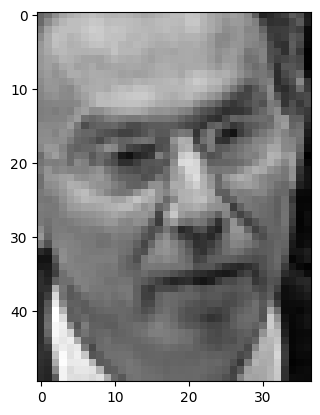

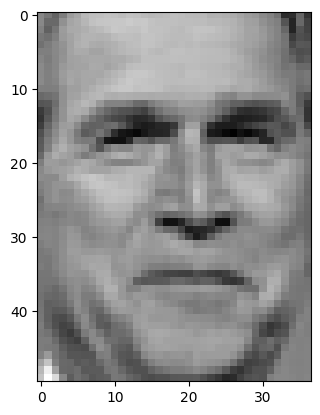

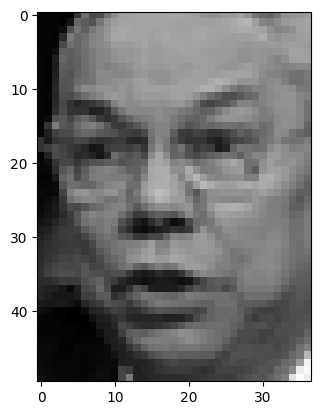

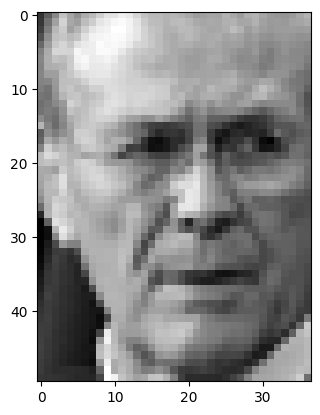

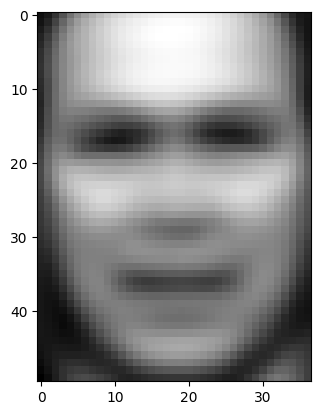

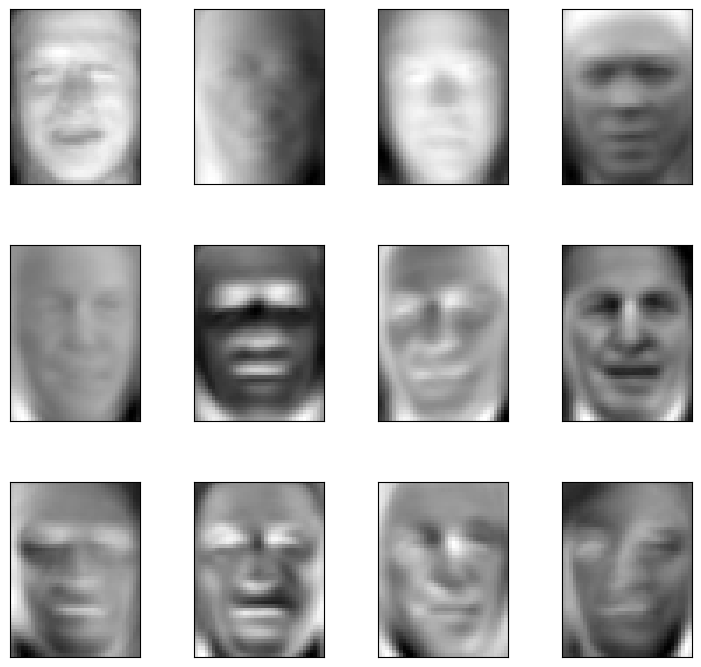

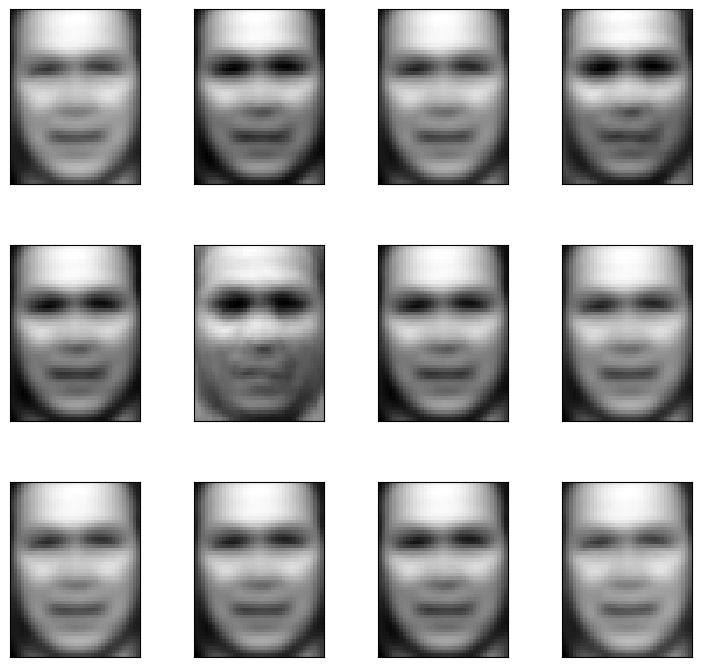

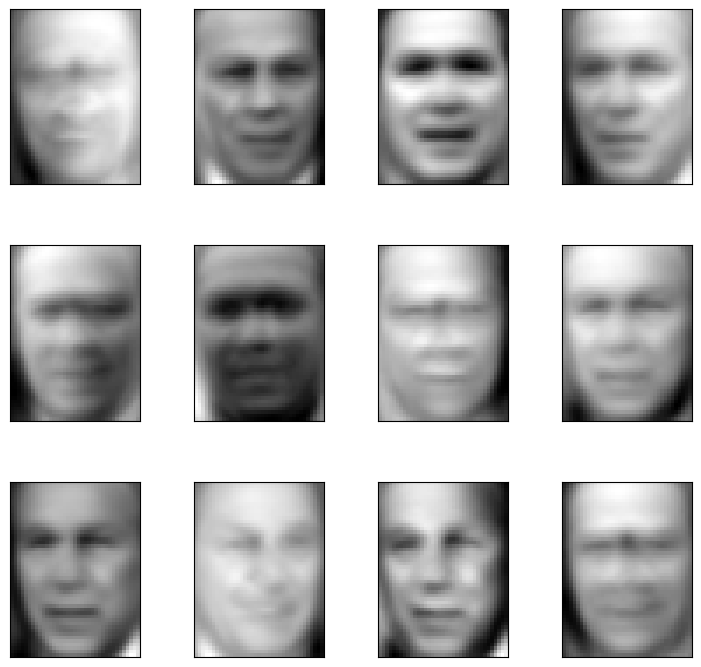

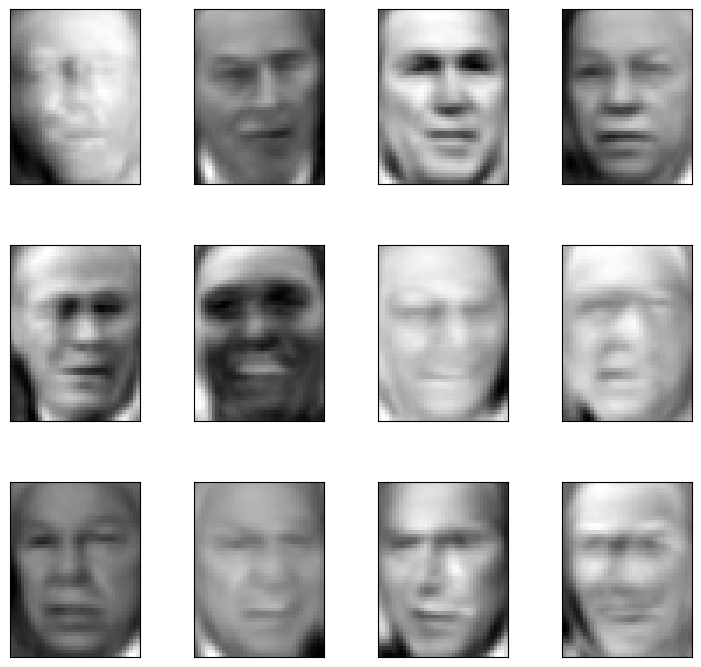

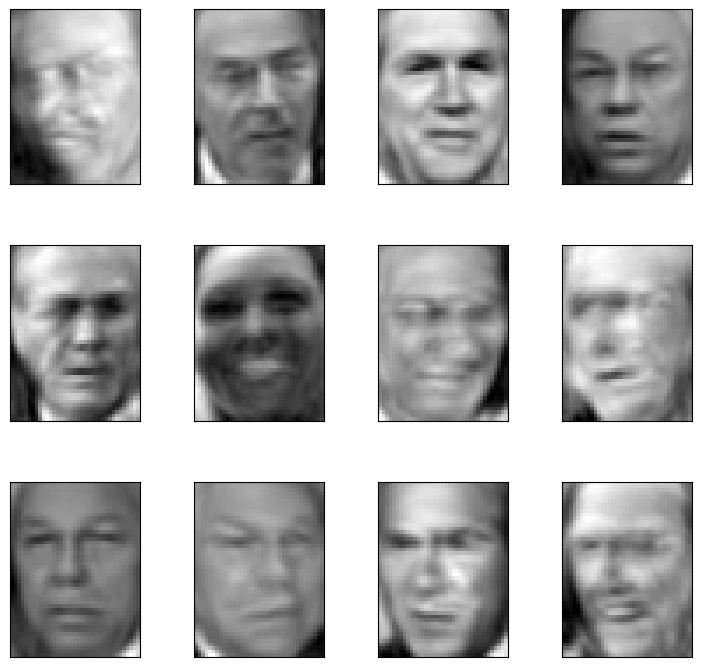

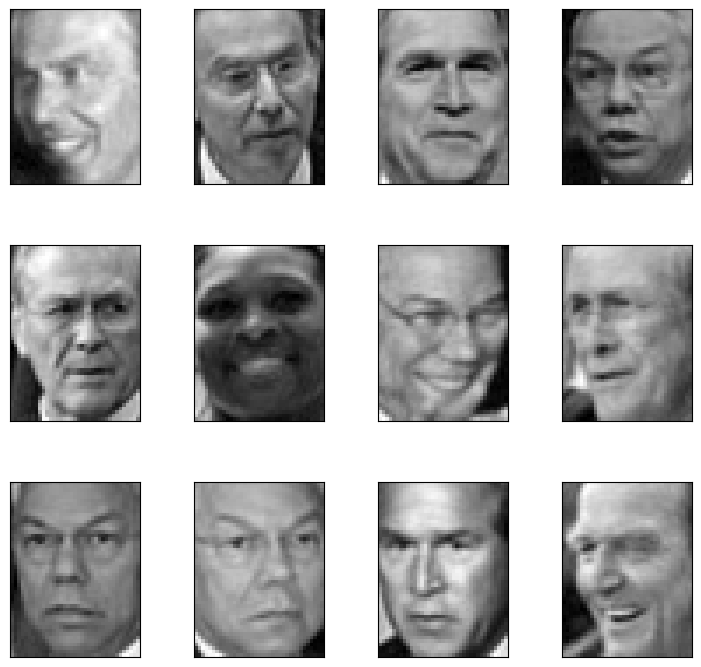

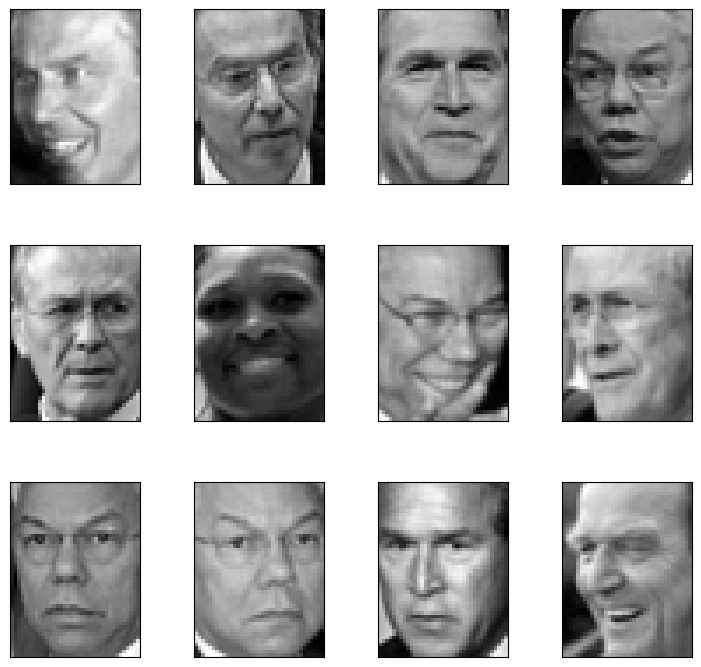

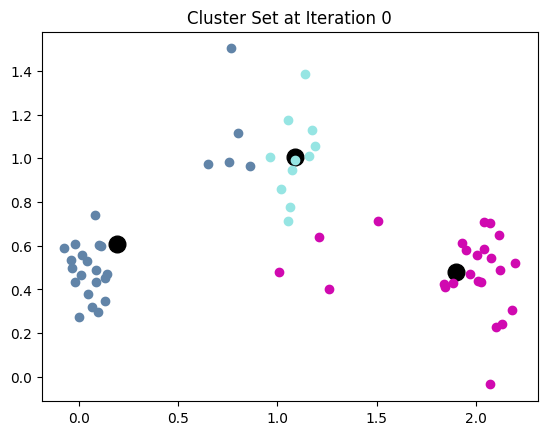

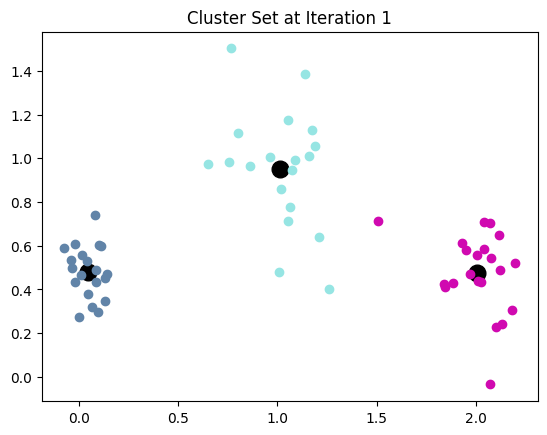

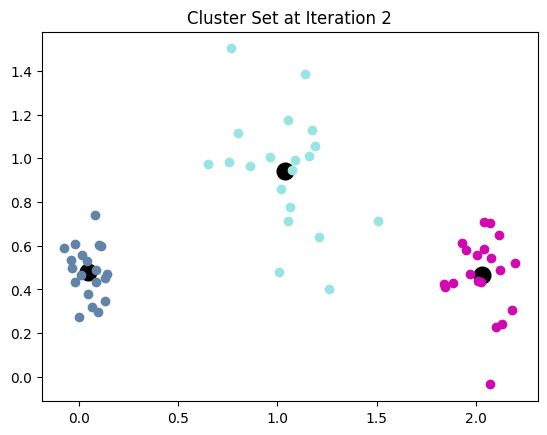

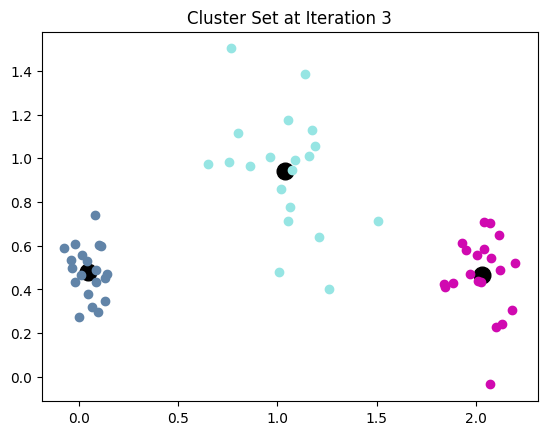

K mean cheat


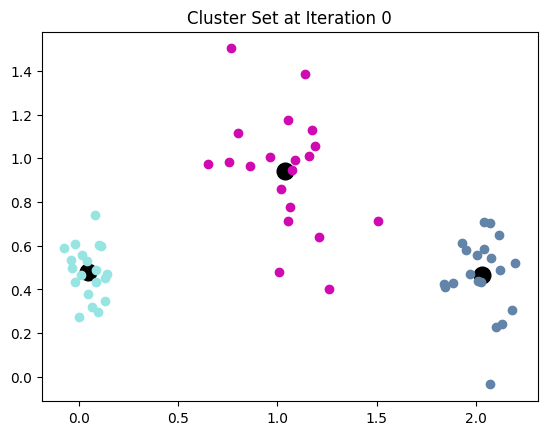

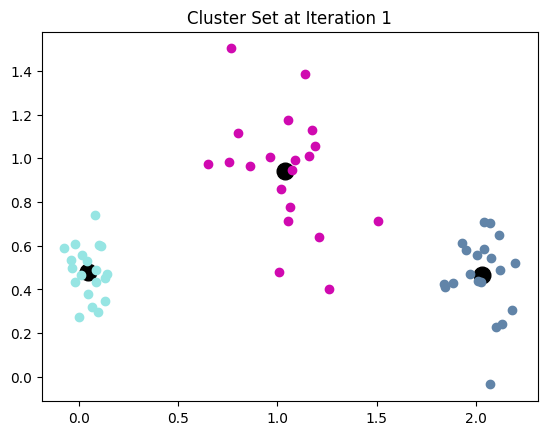

K Medoids cheat


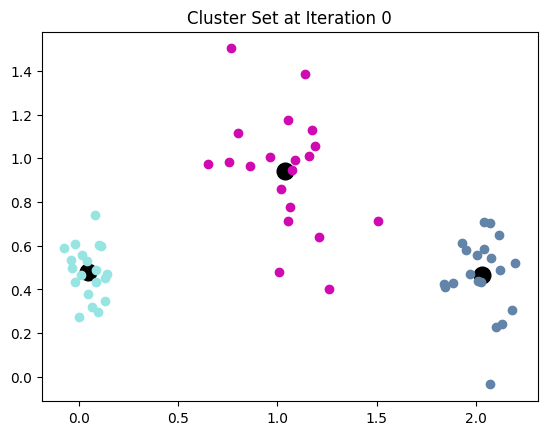

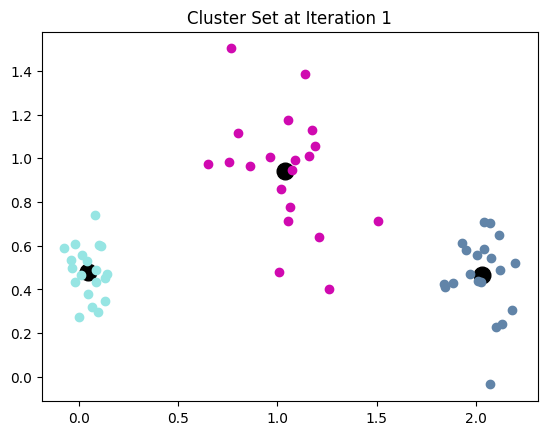

NameError: name 'KMeans' is not defined

In [33]:
######################################################################
# main
######################################################################

def main() :
    ### ========== TODO : START ========== ###
    # part 1: explore LFW data set
    # part a
    lfw_X, lfw_y = util.get_lfw_data()

    for i in np.arange(1,5):
      row = lfw_X[i,:]
      util.show_image(row)

    avg = np.mean(lfw_X, axis=0)
    util.show_image(avg)

    ## Use get_lfw_data(...) to get the LFW dataset with labels,

    # part b
    ## how the top twelve eigenfaces using PCA
    U, mu = util.PCA(lfw_X)
    util.plot_gallery([util.vec_to_image(U[:,i]) for i in range(12)])

    # part c
    ## compare the original image with the reconstructions
    for l in [1, 10, 50, 100, 500, 1288]:
      Z, Ul = util.apply_PCA_from_Eig(lfw_X,U,l,mu)
      X_rec = util.reconstruct_from_PCA(Z, Ul, mu)
      util.plot_gallery(X_rec[0:12,:], title = f"plot {l}")

    ### ========== TODO : END ========== ###



    ### ========== TODO : START ========== ###
    # part 2d-2f: cluster toy dataset
    np.random.seed(1234)
    points = generate_points_2d(20)
    kMeans(points, 3, 'random', True)

    #part 2f
    print('K mean cheat')
    kMeans(points, 3, 'cheat', True)
    print('K Medoids cheat')
    kMedoids(points, 3, 'cheat', True)
    ### ========== TODO : END ========== ###



    ### ========== TODO : START ========== ###
    # part 3a: cluster faces
    np.random.seed(1234) ## don't change the seed !!
    X1, y1 = util.limit_pics(lfw_X, lfw_y, [4, 6, 13, 16], 40)
    points = build_face_image_points(X1, y1)

    k_means_score = []
    k_medoids_score = []
    k_means_time = []
    k_medoids_time = []

    for i in range(10):
        t1 = time.time()
        k_means = KMeans(points, 4, 'random', False)
        t2 = time.time()
        k_means_score.append(KMeans(points, 4, 'random', False).score())
        k_means_time.append(t2-t1)

        t3 = time.time()
        k_medoids = KMedoids(points, 4, 'random', False)
        t4 = time.time()
        k_medoids_score.append(k_medoids.score())
        k_medoids_time.append(t4-t3)

    print("KMeans: ")
    print("Max Purity: ", max(k_means_score),
          "Min Purity: ", min(k_means_score),
          "Average purity: ", np.mean(k_means_score),
          "Max Time: ", max(k_means_time),
          "Min time: ", min(k_means_time),
          "Average Time: ", np.mean(k_means_time))

    print("KMedoids: ")
    print("Max Purity: ", max(k_medoids_score),
          "Min Purity: ", min(k_medoids_score),
          "Average purity: ", np.mean(k_medoids_score),
          "Max Time: ", max(k_medoids_time),
          "Min time: ", min(k_medoids_time),
          "Average Time: ", np.mean(k_medoids_time))


    # part 3b: explore effect of lower-dimensional representations on clustering performance
    np.random.seed(1234)  # don't change the seed !!
    X1, y1 = util.limit_pics(lfw_X, lfw_y, [4, 13], 40)
    U, mu = util.PCA(lfw_X)
    k_means_score = []
    k_medoids_score = []

    for l in np.arange(1, 50, 2):
        Z, U1 = util.apply_PCA_from_Eig(X1, U, l, mu)
        points = build_face_image_points(Z, y1)
        clusterSet_means = kMeans(points, 2, 'cheat', False)
        clusterSet_meds = KMedoids(points, 2, 'cheat', False)
        k_means_score.append(clusterSet_means.score())
        k_medoids_score.append(clusterSet_meds.score())

    plt.plot(np.arange(1, 50, 2), k_means_score, label="kMeans")
    plt.plot(np.arange(1, 50, 2), k_medoids_score, label="kMedoids")
    plt.legend()
    plt.xlabel("Number of components l")
    plt.ylabel("Purity Score")


    # part 3c: determine ``most discriminative'' and ``least discriminative'' pairs of images
    np.random.seed(1234)  # don't change the seed !!
    U, mu = util.PCA(lfw_X)
    k_medoids_score = np.zeros((19, 19))
    l = 50

    for i in range(19):
        for j in range(19):
            if i != j:
                X1, y1 = util.limit_pics(lfw_X, lfw_y, [i, j], 40)
                Z, U1 = util.apply_PCA_from_Eig(X1, U, l, mu)
                points = build_face_image_points(Z, y1)
                clusterSet_meds = KMedoids(points, 2, 'cheat', False)
                k_medoids_score[i][j] = clusterSet_meds.score()

    max_index = np.unravel_index(np.argmax(k_medoids_score, axis=None), k_medoids_score.shape)
    min_index = np.unravel_index(np.argmin(k_medoids_score + np.eye(19) * k_medoids_score[max_index], axis=None), k_medoids_score.shape)

    # Plot
    util.plot_representative_images(lfw_X, lfw_y, max_index, title='max discriminative pair')
    util.plot_representative_images(lfw_X, lfw_y, min_index, title='min discriminative pair')

    # Print info
    print("Most discriminative pair: ", max_index, " purity = ", k_medoids_score[max_index])
    print("Least discriminative pair: ", min_index, " purity = ", k_medoids_score[min_index])

    ### ========== TODO : END ========== ###


if __name__ == "__main__" :
    main()